## Classifying 10 Monkey Species
This notebook includes a simple demo about how to use Tensorflow, wraped inside the Keras API, to fine-tune a pre-trained DNN on a really small dataset for monkey species.

### Dataset
The dataset we used in this example has been made available in [Kaggle](https://www.kaggle.com/slothkong/10-monkey-species). Note that images in the dataset have different sizes, so we run a simple bash script (resizer.h) to resize them to 256x256 px.

### Transfer Learning & Dataset Augmentation
Since our dataset has very limited amount of samples per class (about 100 images), and there is a significant amount of similarities between species, it provides a good chance to check the benefits of transfer learing techniques. Also, data augmentation might help us to make the must out of our few images. 

We  will use a pre-trained model from [Keras](https://keras.io/applications/) repository, VGG-16 to be precise. We chose VGG-16 simply becuase its a bit more familiar to the community, but we could have used residual nets  on NiN (Network in Network) architectures as well.  

The [ImageDataGenerator](https://keras.io/preprocessing/image/) module of Keras covers all the basic data augmentation tricks, so we will be using it in this example.

Let us begin...

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

# --- import Keras modules ---
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.imagenet_utils import preprocess_input as zero_mean
from keras.layers import Dense, Activation, Flatten , merge, Input
from keras.models import Model

# --- import a pre-trained model & utility functions ---
from vgg16 import VGG16 # Available at https://github.com/fchollet/deep-learning-models
from my_utilities import predictions_decoder, confusion_matrix_plotter, plotter

Using TensorFlow backend.


In [2]:
# specify the dataset folder path
TRAIN_DIR = '../dataset_monkeys/training'
VAL_DIR = '../dataset_monkeys/validation'

# --- data related parameters ---
img_width = 224 # determined by the pre-trained model
img_height = 224 # determined by the pre-trained model
batch_size = 32 # we could try other values if we were concerned about the training speed
train_dataset_size = 1098
val_dataset_size = 272
number_classes = 10

# --- training related parameters ---
steps_per_epoch = round(float(train_dataset_size)/batch_size,0) # evaluates to 34
validation_steps = round(float(val_dataset_size)/batch_size,0) # evaluates to 9
number_epochs = 50 # we will train for 50 epochs

Few images, so we use data augmentation. Keras provides built ImageDataGenerator module to perform rotations, shifting, shearing, fliping and zooming operations on the images...

In [3]:
# images will be read from the directories previously defined
# converted to numpy arrays, pre-processed (augmented and normalized),
# and batched before we feed it to the model training method

# --- training data generator ---
train_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',preprocessing_function = zero_mean)

train_data = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True,
    seed = 2)

# --- validation data generator ---
val_datagen = ImageDataGenerator() # no augmentation is used on validation data

val_data = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False)

Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


...lets take random image and examine how the augmented images will look like 

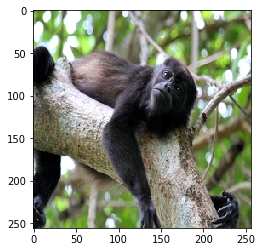

In [4]:
LABEL = 'n0'
IMAGE = 'n0021.jpg'
img = load_img(TRAIN_DIR+'/'+LABEL+'/'+IMAGE) # image loaded as PIL object
_ = plt.imshow(img)

After pre-processing the image we obtain the following variations 

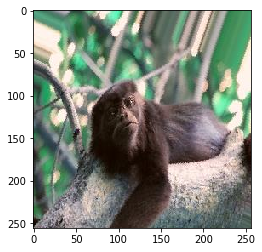

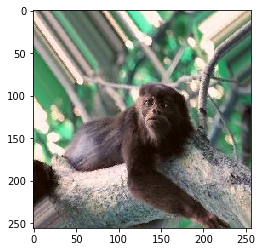

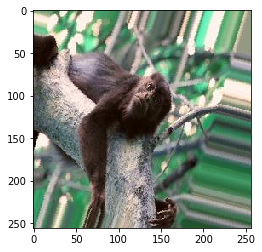

In [5]:
x = img_to_array(img)  # convert the image to numpy array of shape (3, 256, 256)
x = x.reshape((1,) + x.shape)  # reshape to (1, 3, 150, 150), format supported by TF

SAVE_DIR = 'preview'

i = 0
for batch in train_datagen.flow(x,batch_size=1, save_to_dir=SAVE_DIR,save_format='jpg'):
    # flow() generates batches of randomly transformed images 
    # and saves them to the specified directory
    i += 1
    if i>2: break  # prevent the generator from looping indefinitely
        
IMG_PATHS = os.listdir(SAVE_DIR)
for PATH in IMG_PATHS:
    img = load_img(SAVE_DIR+'/'+PATH)
    plt.figure()
    _ = plt.imshow(img)   

... Alrigth, now build the model, replace only the last fully-connected layer from 1000 classes to 10

In [6]:
placeholder = Input(shape=(224, 224, 3)) # input layer to the model (Keras API requirement)
model = VGG16(input_tensor=placeholder, # load the pretrained model
              include_top=True,         # the VGG16 script will automatically download the
              weights='imagenet')       # weigths if they are stored locally

mark the second to last fc layer...

In [7]:
last_layer = model.get_layer('fc2').output
classifier = Dense(units=10, activation='softmax',name='output')(last_layer)

costum_model = Model( placeholder, classifier)

for layer in costum_model.layers[:-1]: # fix weights from all but the new layer
    layer.trainable = False

In [8]:
costum_model.compile(
    loss='categorical_crossentropy', 
    optimizer='adadelta',
    metrics=['accuracy'])

costum_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Observe that only a partial number of parameters can be trained (we imposed this restriction, of course)
... Now start the training

In [9]:
t = time.time() # set the timer

hist = costum_model.fit_generator(
    generator = train_data,
    steps_per_epoch = steps_per_epoch,
    epochs = number_epochs,
    validation_data = val_data,
    validation_steps = validation_steps )

print('-'*40)
print('Training time: %s min' % ( (time.time()-t)/60 ))

Epoch 1/50
34/34 [==============================] - 13s 391ms/step - loss: 1.1140 - acc: 0.6464 - val_loss: 1.5166 - val_acc: 0.5331
Epoch 2/50
34/34 [==============================] - 10s 291ms/step - loss: 0.3118 - acc: 0.9099 - val_loss: 1.4478 - val_acc: 0.5956
Epoch 3/50
34/34 [==============================] - 10s 285ms/step - loss: 0.1926 - acc: 0.9439 - val_loss: 1.3328 - val_acc: 0.6103
Epoch 4/50
34/34 [==============================] - 10s 286ms/step - loss: 0.1610 - acc: 0.9577 - val_loss: 1.3357 - val_acc: 0.6324
Epoch 5/50
34/34 [==============================] - 10s 285ms/step - loss: 0.1367 - acc: 0.9623 - val_loss: 1.3158 - val_acc: 0.6360
Epoch 6/50
34/34 [==============================] - 10s 285ms/step - loss: 0.1114 - acc: 0.9623 - val_loss: 1.3120 - val_acc: 0.6691
Epoch 7/50
34/34 [==============================] - 10s 289ms/step - loss: 0.1006 - acc: 0.9688 - val_loss: 1.1617 - val_acc: 0.6765
Epoch 8/50
34/34 [==============================] - 10s 284ms/step - 

In [10]:
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(number_epochs)

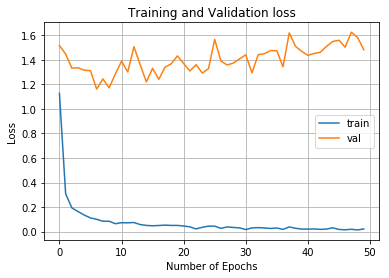

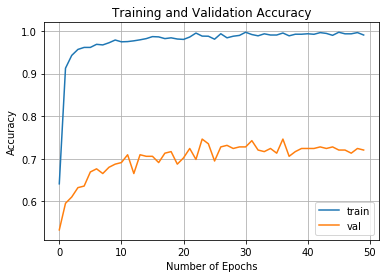

In [11]:
plotter(xc, train_loss, val_loss, 'Loss', 'Training and Validation loss')
plotter(xc, train_acc, val_acc, 'Accuracy', 'Training and Validation Accuracy')

We observe overfitting, maybe the fc classifier is too big, lets try making smaller (fine-tune last 3 layers)

### Finetunning

We now ignore the 3 fc layers from the original VGG16 model, and thus, grap the pooling layer that follows the last convolution block so we can place a new FC classifier on top

In [13]:
last_layer = model.get_layer('block5_pool').output

x= Flatten(name='flatten')(last_layer) # flatten the output of the pooling layer and pass it to the FC
x = Dense(512, activation='relu', name='fc1')(x) # fc1
x = Dense(512, activation='relu', name='fc2')(x) # fc2
out = Dense(units=10, activation='softmax', name='output')(x) # softamx output

custom_model2 = Model(placeholder, out)

for layer in custom_model2.layers[:-3]:
    layer.trainable = False

custom_model2.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])
custom_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [14]:
t = time.time()

hist = custom_model2.fit_generator(
    generator = train_data,
    steps_per_epoch = steps_per_epoch,
    epochs = number_epochs,
    validation_data = val_data,
    validation_steps = validation_steps )
print('-'*40)
print('Training time: %s min' % ( (time.time()-t)/60 ))

Epoch 1/50
34/34 [==============================] - 11s 317ms/step - loss: 13.5729 - acc: 0.1504 - val_loss: 13.3185 - val_acc: 0.1581
Epoch 2/50
34/34 [==============================] - 10s 297ms/step - loss: 12.5859 - acc: 0.2115 - val_loss: 13.5076 - val_acc: 0.1581
Epoch 3/50
34/34 [==============================] - 10s 307ms/step - loss: 11.7271 - acc: 0.2638 - val_loss: 12.2170 - val_acc: 0.2316
Epoch 4/50
34/34 [==============================] - 10s 296ms/step - loss: 11.1889 - acc: 0.2949 - val_loss: 11.5105 - val_acc: 0.2574
Epoch 5/50
34/34 [==============================] - 10s 306ms/step - loss: 9.4117 - acc: 0.3912 - val_loss: 9.2698 - val_acc: 0.3934
Epoch 6/50
34/34 [==============================] - 10s 305ms/step - loss: 8.1337 - acc: 0.4680 - val_loss: 9.9075 - val_acc: 0.3566
Epoch 7/50
34/34 [==============================] - 10s 305ms/step - loss: 7.9463 - acc: 0.4864 - val_loss: 9.8410 - val_acc: 0.3529
Epoch 8/50
34/34 [==============================] - 11s 310ms

In [15]:
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']

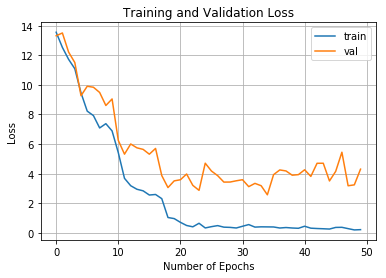

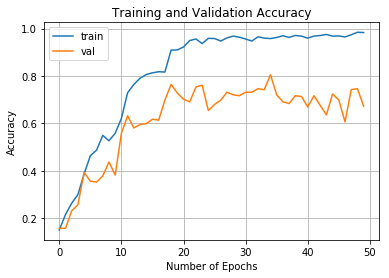

In [16]:
plotter(xc, train_loss, val_loss, 'Loss', 'Training and Validation Loss')
plotter(xc, train_acc, val_acc, 'Accuracy', 'Training and Validation Accuracy')

Lets save the model and observe if we can get better results by prolonging the training a bit more

In [18]:
model_name = 'costum_model2'
save_dir = '../models/' + model_name + '.h5'
custom_model2.save_weights(save_dir)
#costum_model.load_weights(save_dir)

In [19]:
t = time.time()
extra_epochs = 5

hist2 = custom_model2.fit_generator(
    generator = train_data,
    steps_per_epoch = steps_per_epoch,
    epochs = extra_epochs,
    validation_data = val_data,
    validation_steps = validation_steps )
print('-'*40)
print('Training time: %s min' % ( (time.time()-t)/60 ))

Epoch 1/5
34/34 [==============================] - 11s 312ms/step - loss: 0.2933 - acc: 0.9733 - val_loss: 3.3766 - val_acc: 0.7353
Epoch 2/5
34/34 [==============================] - 10s 308ms/step - loss: 0.2636 - acc: 0.9766 - val_loss: 4.2833 - val_acc: 0.6838
Epoch 3/5
34/34 [==============================] - 10s 306ms/step - loss: 0.3122 - acc: 0.9738 - val_loss: 4.2271 - val_acc: 0.6875
Epoch 4/5
34/34 [==============================] - 11s 311ms/step - loss: 0.2302 - acc: 0.9770 - val_loss: 3.5845 - val_acc: 0.7279
Epoch 5/5
34/34 [==============================] - 10s 301ms/step - loss: 0.2076 - acc: 0.9761 - val_loss: 3.7304 - val_acc: 0.7206
----------------------------------------
Training time: 0.873801000913 min


In [20]:
train_loss2 = train_loss + hist2.history['loss']
val_loss2 = val_loss + hist2.history['val_loss']
train_acc2 = train_acc + hist2.history['acc']
val_acc2 = val_acc + hist2.history['val_acc']
xc=range(number_epochs + extra_epochs)

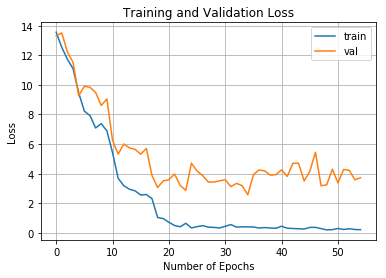

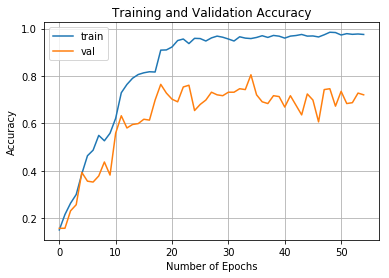

In [21]:
plotter(xc, train_loss2, val_loss2, 'Loss', 'Training and Validation Loss')
plotter(xc, train_acc2, val_acc2, 'Accuracy', 'Training and Validation Accuracy')

So the final loss and accuracy of the model is...

In [22]:
custom_model2.evaluate_generator(val_data, validation_steps)

[3.7304116627749275, 0.72058823529411764]

Lets examin accuracy for each class to get a better insight on what is happening. We will calculate the confusion matrix. On way to do this is by using the scikit-learn library. Before we were letting Keras load the data batches upon request of the training method. Now we need to manually forward the data so as to calculate the matrix, so we should load the validation images, convert them to np arrays and stack them in a tensor of the proper dimensions

The following cell does exactly that; it builds a tensor with the converted data, X is images, Y is labels.

In [23]:
batches = 1
DEBUG = False

for x_batch, y_batch in val_data:# read the data from disk using the same data generator as before
    
    # Build X_test and Y_test tensors by concatenatining the batches
    if batches == 1:
        X_test = np.copy(x_batch)
        Y_test = np.copy(y_batch)
    else:
        X_test = np.concatenate((X_test, x_batch), axis=0)
        Y_test = np.concatenate((Y_test, y_batch), axis=0)
        
    if DEBUG:
        print("--- Batch #: {0} ---".format(batches))
        print("X.shape: {0} , Y.shape: {1}".format(X_test.shape, Y_test.shape))
    
    
    if batches >= validation_steps:
        break # we need to break the loop by hand becaus
              # the data generator loops indefinitely
    batches += 1

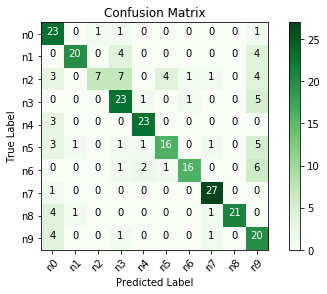

In [36]:
# Printing the confusion matrix
from sklearn.metrics import classification_report,confusion_matrix

Y_pred = custom_model2.predict(X_test) # forward the validation set to generate predictions
Y_pred_idxs = np.argmax(Y_pred, axis=1) # and extract the index number of the must probable class in each case

target_names = ['n' + str(i) for i in range(10)] # simplified labels are n0~n9

# Compute confusion matrix
cnf_matrix = (confusion_matrix(np.argmax(Y_test,axis=1), Y_pred_idxs))

#np.set_printoptions(precision=2)
confusion_matrix_plotter(cnf_matrix, classes=target_names)

# We can adiationally print out a report on the classification stats (recall, f1-score...) 
# by uncommenting the following line:
# print(classification_report(np.argmax(Y_test,axis=1), Y_pred_idxs,target_names=target_names))

Save the model for later use

In [37]:
model_name = 'costum_model2'
save_dir = '../models/' + model_name + '.h5'
custom_model2.save_weights(save_dir)
#costum_model.load_weights(save_dir)

Looking at the confusion matrix we observe n2 has the lowest accuracy of all classes. Just for curiosity, lets look a  random sample of this class

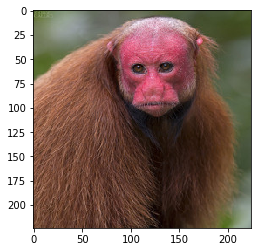

In [43]:
LABEL = 'n2'
IMAGE = 'n2013.jpg'
img = load_img(VAL_DIR+'/'+LABEL+'/'+IMAGE, target_size =(img_width, img_height)) # image loaded as PIL object
_ = plt.imshow(img)

Note that must of the errors in the confusion matrix correspond to n2 samples being confused with n3. This is perhaps understandable since n3 corresponds to the Japanese Macaque, with presents similar skin color (red face):

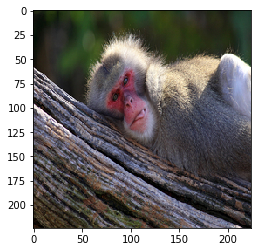

In [50]:
LABEL = 'n3'
IMAGE = 'n3011.jpg'
img = load_img(VAL_DIR+'/'+LABEL+'/'+IMAGE, target_size =(img_width, img_height)) # image loaded as PIL object
_ = plt.imshow(img)